In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My Drive/BE project

/content/drive/My Drive/BE project


In [3]:
!tar -xzvf cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip install tensorflow-gpu==2.0

In [ ]:
!nvidia-smi

Mon Apr 20 22:21:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim

import pickle

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
df = pd.read_csv('16million_tweets_header.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,0,0.0,1.467811e+09,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1,0.0,1.467811e+09,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,2,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,3,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,4,0.0,1.467811e+09,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
df.tail()

,Unnamed: 0,target,id,date,flag,user,text
1599995,1599994,4.0,2.193602e+09,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1599995,4.0,2.193602e+09,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1599996,4.0,2.193602e+09,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1599997,4.0,2.193602e+09,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1599998,4.0,2.193602e+09,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1600000 non-null  object 
 1   target      1599999 non-null  float64
 2   id          1599999 non-null  float64
 3   date        1599999 non-null  object 
 4   flag        1599999 non-null  object 
 5   user        1599999 non-null  object 
 6   text        1599999 non-null  object 
dtypes: float64(2), object(5)
memory usage: 85.4+ MB


In [ ]:
df['target'].value_counts()#.plot(kind='bar')

4.0    800000
0.0    799999
Name: target, dtype: int64

In [ ]:
df.target.fillna(0,inplace=True)

In [ ]:
df.target.isnull().sum()

0

In [ ]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [ ]:
df.target.head()

0    NEGATIVE
1    NEGATIVE
2    NEGATIVE
3    NEGATIVE
4    NEGATIVE
Name: target, dtype: object

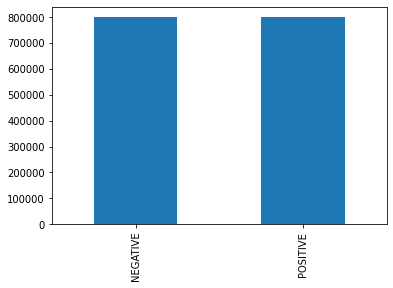

In [ ]:
df.target.value_counts().plot(kind='bar')

## pre-process textdata

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

before pre-processing text

In [ ]:
df.text.tail(3)

1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, dtype: object

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

text after pre-processing

In [ ]:
df.text.tail()

1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


# Word2vec

In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [ ]:
w2v_model = gensim.models.Word2Vec.load('model.w2v')

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30333


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 18min 43s, sys: 3.79 s, total: 18min 46s
Wall time: 9min 38s


(263072385, 295206432)

In [18]:
w2v_model.wv.most_similar("queen")

[('queens', 0.32037264108657837),
 ('poppins', 0.28221240639686584),
 ('legends', 0.27797791361808777),
 ('gothic', 0.26739567518234253),
 ('crowned', 0.258863240480423),
 ('hooker', 0.25485676527023315),
 ('topped', 0.25178056955337524),
 ('albans', 0.2511996328830719),
 ('culver', 0.25090402364730835),
 ('oxford', 0.24819333851337433)]

In [ ]:
w2v_model.save("model.w2v")

### Label encoding

In [19]:
labels = df_train.target.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [20]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


### Preparing X_train and X_test

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290570
CPU times: user 17.5 s, sys: 113 ms, total: 17.6 s
Wall time: 17.6 s


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [23]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1280000, 300)
y_train (1280000, 1)
X_test (320000, 300)
y_test (320000, 1)


In [ ]:
X_train[-10:]

array([[    0,     0,     0, ...,     1,  1638,   287],
       [    0,     0,     0, ...,   128,  3082,    14],
       [    0,     0,     0, ...,  2377,   989,   217],
       ...,
       [    0,     0,     0, ..., 43477,  1720,    69],
       [    0,     0,     0, ...,   313,   113,   797],
       [    0,     0,     0, ...,   138,  1367,   370]], dtype=int32)

# Embedding layers

In [24]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290570, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [30]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))

model.add(Conv1D(250,
                 4,
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(GlobalAveragePooling1D())

model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87171000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 297, 250)          300250    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16064     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation (Activation)      (None, 64)               

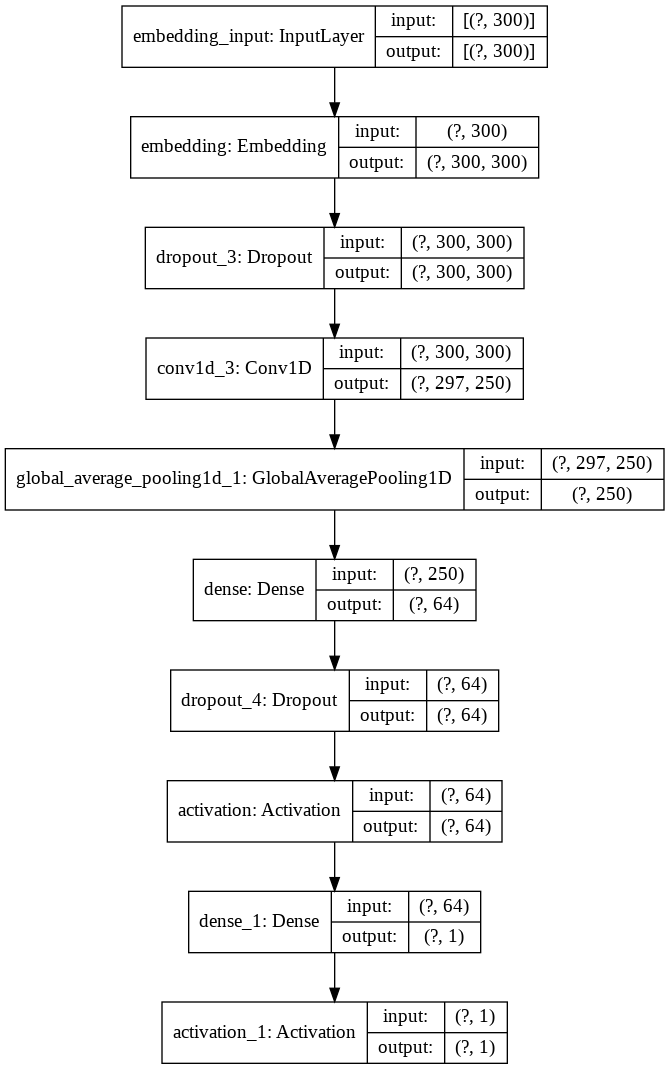

In [32]:
utils.plot_model(model,to_file='CNNTextclassifier.png',show_shapes=True)

In [ ]:
opt = Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tensorflow.keras.metrics.Precision(),tensorflow.keras.metrics.Recall()])


In [35]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/10
1152000/1152000 [==============================] - 880s 764us/sample - loss: 0.4817 - accuracy: 0.7671 - precision: 0.7649 - recall: 0.7714 - val_loss: 0.4591 - val_accuracy: 0.7812 - val_precision: 0.7620 - val_recall: 0.8153
Epoch 2/10
1152000/1152000 [==============================] - 874s 759us/sample - loss: 0.4614 - accuracy: 0.7797 - precision: 0.7773 - recall: 0.7842 - val_loss: 0.4494 - val_accuracy: 0.7867 - val_precision: 0.7771 - val_recall: 0.8015
Epoch 3/10
1152000/1152000 [==============================] - 867s 753us/sample - loss: 0.4535 - accuracy: 0.7843 - precision: 0.7823 - recall: 0.7882 - val_loss: 0.4462 - val_accuracy: 0.7903 - val_precision: 0.7802 - val_recall: 0.8058
Epoch 4/10
1152000/1152000 [==============================] - 868s 754us/sample - loss: 0.4473 - accuracy: 0.7878 - precision: 0.7856 - recall: 0.7920 - val_loss: 0.4438 - val_accuracy: 0.7905 - val_precision: 0.7779 - val_recall: 0.

In [ ]:
model.save("sentiment_classifier_CNN.h5")

In [37]:
score = model.evaluate(X_test, y_test, batch_size=256)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




ACCURACY: 0.79124063
LOSS: 0.443778798866272


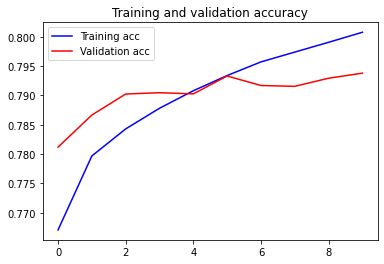

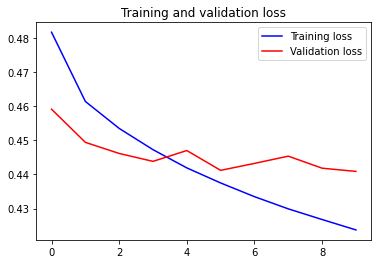

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
model = load_model("sentiment_classifier_CNN.h5")

In [ ]:
tokenizer = pickle.load(open("tokens.pkl", "rb"))

In [ ]:
import time

def decode_sentiment(score):
  return "NEGATIVE" if score < 0.5 else "POSITIVE"

def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    out_put = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(out_put)

    return {"label": label, "score": float(out_put)}  

In [10]:
predict("I love the music")

{'label': 'POSITIVE', 'score': 0.9618959426879883}

In [11]:
predict("this is so disgusting")

{'label': 'NEGATIVE', 'score': 0.043146830052137375}

In [43]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE', 'score': 0.35156717896461487}